In [1]:
!pip install --upgrade pandas numpy matplotlib seaborn tensorflow lime scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 844.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.7 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d6dc184c26f9e0b0f86fda4596340c628e9ac9c7d7fcc08b321f3707d31daf27
  Stored in dire

In [3]:
!pip install --upgrade numpy scipy

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatib

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

4905/4905 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step

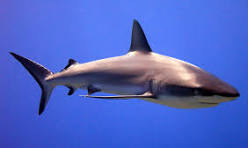

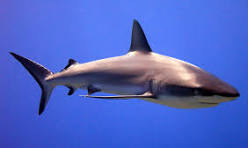

In [3]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAJQA+AMBEQACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAABAgAEBQYDB//EAD8QAAIBAwIDBAcFBwEJAAAAAAABAgMEEQUSITFBBhNRYRQiMnGBkdEVUqGxwSMkM0JicuFDB0RFU1SCkpOi/8QAGgEAAwEBAQEAAAAAAAAAAAAAAAECBAMFBv/EAC8RAQACAgEDAwMDAwQDAAAAAAABAgMRBBIhMQUyQRNRYSJxkRQVgVLB0eEzQrH/2gAMAwEAAhEDEQA/AM8+r0z7FFIkyGg/QYFAWjYKTocANIkMhSGWjICOhpkQMGAQCQC0cDDAyQQQBAAJKA2DGChofsj5CBRkViMoGDEZXyAaI0IaJLkIz5OTXMwKGgyKI6GnY5ATJhpFDG0GWxQEdMCPnPQYlECUYzASdiCtimCdpzGaAQpCBZIcEHQDKMtFaQjAADEOwAO5WB6K/IDI8iPYMARiAo4w1TIoqITJkNEydMZSZDBsjTvaIY8CBbECMhkdADAXgBhAGgACBKeqXvoFt321Se5LDM/Jz/Rp1QulOqdG06/o6hb9/R8XGUesX4FYc0Zq9UFavTOpXG/A76SUNEAGDERZBpWygQAAYArDSiPmIitge5IxCSsDFHFpMuJUIkRoMmOIBhgyYyEEyYDFcwIwxo0QTJhkPQDRgC4AbHkEl4Yfaif7C3hn2pOXyX+UeX6lbXTDTxo7zLC0G/8As7WFCcsUbh7JeT6P9DNw83076+JdMtOqHddWe6w6QNnor4DGgYaBWAKAL1AAwGiikyyAEYjKwBBCByctNApjIyZSJMhwDoCMhkKAjDNEBGQEdMYNkClALacwHlAAPiAc72nn+9W0PCEn82voeP6lP66x+GvjeJcnqS5tNp9H4HntEu+0DUHqOk29xJ5m1tqLwmuD+vxPoeNk+piizz8tem8w0TRCAYAGAKwBGByHUCKwGysAViOCsRvNsC2VsRimc2gUxkZDhJ0NIpjM4EKAjZGUymQIUMHQgZDIQAgAGSMRuR7T1t2rqC493RSb822/1R4fqFt5tfaGzjV/Rtg3kW1nDMUS7zDU7DX6oXlWwqvhW9en/clxXyPR4GbV5pPyz8im427lrD4PK6HswxhgADAFYAj5gZWAKwIGA0SXAStFbDRPNgRWKTj8ojk0+WdeazDT7iMLy3qQpS9mtH1ov9TNk5X0rdN47fEqrj6o3DQtrmjdQ329WFSPjB5NFMlbxus7RNZjy9joiYPEBo2RpMmMhQFBgE6FDEGTEZ0xpkUBdxwBhwDYXLTTLy8koULectz9pxxFfEzZuTjxV3MulMVrzrS9L/ZjZzTvdQ1Ocqk1ulClTSz7m+nwPl8/Kve0313l6ePFERFXN6v2Op02/Q5SnHplEVzzPlonBVi6d2Ju7jUaMt9S22zTVRQ3YZ0jkdH6o8w5zx4t2fR7rsfqVGnvozo3KxnMHhv4M9nB6vhtERftLzsnFvE9mLcWd1bZVxb1aeOriz0qZseT2W2z2xzX3QrvB1T8PNjJ5sAUYKxAABJMBsjECSAdyZAtjk46bOzyurajd286FzHdCS4r6E5KRkr02hMTNZ3DjNR0670Wuq9vWn3Dl6tWLw8+DPHzYL4J38fdppki/lp6V2rkp93qkHJL/VpLEl748n08H7zpj52SnujcCcNZ8OrtalO6pd/aVY3ENu6XdvjFea5o9HFyseXxOvwz2xWr5PnJp/dwk0QM/QC7MrtFqs9LtqUqEIznUnt9fikjHzORbDEdPmXbDjjJPdb0K4udVspV3Z1IuCzJx4r4dScHPpftftJ5MFq+1r22nXty8ULWtN/0xeDVfkYae60OUY7z4hs23ZLUqizW7qhw/nnl/JGHJ6rx6+O7tXiZZX6PZSwpYd1qFWflSio/i8/kYsnrV59lP5d68D7yu0tK0O34q371+M5OWf0Ml/VOTb51+3Zorw8cfD1V5ZW8dtvaU4ecaaRmtyMt/daZ/wAu1cFI8QH2xNLEU15o5r6YVat9Uq53ZYDUK8q3jAUrNRu405p7H8GKRpuWGrUnFqe6L8+JE7TNdrju7et6vqY94VtNU/TV6+i6XfQbqWtFz8Y+rL5rn8TZi9Qz4vFp/wA92e/Gx28w5/UeyFvF/ut7Kk/u11lf+S+h6mH1qfGSv8f8f9st+BPmkucvtF1Czi51aG+muc6XrRXyPVw8zBm9lu/8MeTDenuhl8+RqcitjBGwANgCMkySYCSNgEycYahb4DTMkrUKdzRnRrRUqc1iSYr0reOm3gomY7w4bVtNqabX2TW6jN/s6n6PzPCz4Zw21P8Ahspfqglld3NlVVS3qzhJPPqScc/I4S6Vl1umdqIXjcNTioVXhRq0IYT/AL1n8V8U+Zs4/Nvj7W7x/wDHPJhreOzextbScZJdYtNY8T2MeWmSvVSezFfHak6ks6kYuEcSlKTxGMVub/x5k5s1MUbtIpjm/aFzQOyM7rUvtftTGM6dKf7tZ7v2eOjfWX4fofM8rmWzWm38fh6mHjdMPpFtf6VaUX3cLelnniKXwS6GCbXmWj6cKtz2m0+nnFwm10SxgNWsqIrDHuu21sk405JsuMdpHVWGXV7W0JSbzGLL+lKZvDzj2qpYajJvPgsC+lI6yPtHCXJIIpKuuNHh2iXVx+QdMlvZ32gp49pBo4kj1+D8xdKtw9KWpqfFQFo5lZp6o4S2uLQpgoXaGp7pewmvFsmYU17G/g3iUXH3MmYKYaNdW95RlGVR8uAonSdTDjdUhf6XcOVrXklnPB8zRW1Z8pmsyyrjUbS+z6dbxhcL/Wox2yfvS4P5HpYOdmxdoncflky8XHfvrUsyrGMXmDUk/wCZdT2sHOx5Y+0vOyca+P8ALzfgbduHfwVgWiNiEQRhsySEaHKGmfwOeA0m4Y5jgnhfWtG+tZ29xDMJcU1zi+jRzy4a5a9Nji017w4mvazsbt2dy+XsT+8jwclJx2mtmytuqOzY7N6JU1K+7pbIwXrTlOexJe8537V2607y764vOzej2tvaK69MlRnKSjTXJtYlxXNcFw+Jnx5M+907O94x6/X3Zd720eNun2SpKKwpbVnBf0LW90uf1aV9sMur2k1Kvxk5Z6ZkOOPEJnPKnU1TU6mcVnDzXMuMVYROWVOrK8qPNSvN/EvoqnqmXlsqffb+I+mEzMlbqLqGoPcg69WPKbJmIVuU9OrrlNi6YOLnjqFy3zZzmkKi8rVC4vKjWEviTNari1vhsWVCvUw6klFdTnLpG/lpK/jR/Z03BRgvWkyHTs1bGNO7h3k6sZPPFRZEqhZ76nRniHP7ogs2+owjJZmhTBw6bSdRt6qVObivBtnOYE91/Ubeyq0N01Sbxw4hEymu9vnPaalQo1U6cF63RLBopaRarmncbG0nj4neLalzmImO4K7knlNYPR4/Ovj/AGYsvGrbwsU60akcx+R7GHkY8sfpl5+TDak9xyaEFbAnnJiCZOUNQrkNMmTHBCnxGlna5psdStGv94p+tSkuj8PczLy+PGWu48x4dMd+iWHpl0qtvKjXT3Re2azzZ4sd2uZadCjBPbBYb5Y6kzN9xEHGtbmV5WE0uSz4ZNUcLkT41/Lj9bHHlQubina1O7uoulnlu6ryM2SmXHbVodKzW3hZhTpzhuhLKOU3tHmFdO3jW7tReNzS45xwwXHVMbKdR2UbWVO5qOKltXRvkzpWIlMrdXTsLKmmvLiVNYLavLTpC6VbebsKn3SekbgY2lVB07VuFmjCvDpkmcWzi+npO4uYxxhxXkT9F0jIrX1RqjHc3lyW5pviHRops3FrFSjYxpwwuEVlc+WDhOPcri6lX1121FKjJt4W588i+kr6ulNdqZQf8OXHwYvpyPq/doWXbChTku+qTj04oi2KVRliXR6f2106pt7yuvD1mcpxS7VyVXdRvdF1Ok5rUqNKUY52zkOsWj4FpiY8uKu7q2jUcKVaFTD5o7fu57+yo7j1uD4eRW4TMPenWqJqUJLHhk6UyTWdwi1IntK5Svc8KnQ9bj+oz4yd2LLxY81e6nGccxeUetS9bxussFoms6kMlFEpk5NUingaDJjgCmUQ5655AW3IXUow125jTSxKaz7z5/PqM1tfdtp7Il0WlUtznVfHHqxf5m7gYtzOSXHLbtpqKT8T1GVgdsJVallStbe2qVp1p84wztXy4M831CZmsUrG9u+CIiZtMr2hadO0tKUKvGu1hx548i+NxK469WXyWTJNp1VqT0udRODs6vrLGFTZWXHxZrMzMfyVJybiIcXadndSlJQknTguDlUT/BHmYeLlyx1R2hqvlrTtby3LLR3a/wAW9lUWMYawjXPpl9e5w/qY+y16I+k4v/uOU+ncmPGpVHIxyDs6z/h0pz/tWTPfByKe6rpF6T4kY2V3/wBNW/8AXL6HGMv3V0yZ2l5h7bK5l5KjL6FRmr9x0Sq+iapdSVOhpV5Jt4TlRlFfNpIc5qxHlVaWmdLWqdjLulYupWvrP0hQ3OkqqSj5ZfNmSeRufDRGLt3cvO5n6tOPGUWm0nnidYnblMdMknQnOlh02ikTZn1qNWM/ZePcTIV5xmuaJVuXnKDlzj+BMyINC1jK2eFN1E+iJPas5VaL2pyTRMwcWmFi2vLpyxBVJvwisi7Qv6kri1apQeatKcZf1LAKjJCxS7Qwf8WD96KiR1xtZttet4XEEpScZPDWORt4nJnHaI+JZs+Ot426TPyPo47xt5nymTnDTIoaDIcAU8FJGUkk5PpzCZ0J+zh7ScrnWZzXFOTlw9585G8l5n7y3TERV3FtT7qjGn4c/efQYqdFIhhvO5eyOqDJ8OHD3BBaHoVHYaBxi4yi4pqWNyaznHic7Y6X90bVFpjxJXRi08Trwz/y684fkzlPEwT/AOsKjLePkncVlxp6nqkH/TfVP1Zzn0/DPjt/k/6i8J3N7L/jmrR8vTKi/JnO3pmKfmVRyr/j+E9EuJe3q2pTxz3XlV5/+iP7Th+8nHLv9g+z1L2rq4mvCdWUvzkH9pxf6pH9ZdPs21fCcZS9839S6+mYI+Z/lM8vJPh5y0ezlld1hf3P6nLL6Tit7bf7rry7/Lwrdn7Kaw7d48qsvqYMvpnIr7e7tXk1nyrU+z9vb1t9GVVf0yeTJNM2P31l1ia28SvqjiO2SOf1oHRBZW1N84If1D6HhV06i3lU4i6z6SKxoReXTivgT1wNaOoU6aSXsrpjIptPwNPJuybedmeu6DJmbfZWoBOzTTjUop+WELq0NG7ijVX8s4vpjKO2PDmzf+Ou0Wtjp7peU9JtJcVbUt3nFGunpfJtPfs5zycceO5rfTLag89zRT8oHp8b02mK3VaeqWXJnteNQuN8Gz05Z4j5DccoapMnwKToUxkORlLxvqvd2Vef3acn+Bx5FunFafwdY3MOb7G27ncVbiUW4wWF5s830/D1W658Q0ZrajTsIvHPmeyxmTGRkxhNwy2KYAUwA54jBtwJFAWkzkD2ORlqEUmI0yATIpiJ8iJI4x54Rmy8LDkj9VXSua9fEkdNeJ59/R8c+20x+7vXlz8wTY0ZrejX+LQ6RzI+0klTzzI/tGX/AFQr+spPwR017i49HyfNkzyo+IK6UfE6R6N97pnlfaCunFckvkdqej4Yn9UzKZ5V/iE4Lgkj0seGmKvTWNM1rTed2TPHJ08eCgrYDRWxCEOUNehTKTMCmOE6HI0luKMLi2q0amVGcXFtc+JGTHGSs1n5VW2pG0t6VrQhRoR2wjyX6jx46469NfCZmbT3WEy0imMDkaZkcjLRkxScaTIy2KfAYMpBohUgHwikMoHcATIj2m4C2G4DRyAtyDYH5I2IFkxlJWxAjYpVBGwImRSIBsD8FbFJbK2BwmTk1DkcFIplJMmAFMcEZMadmyMSdPbyAtaHIQSbii2ZMB2RSAomRzxADkYFMC7DkZSmQCZEAbADu4Ae+wOQF3ByAFbAyOQgVsARsAVsDLkkBkWwVsBsjfABCZOTXJkxpmRTHCTJjA5GRkwIUxloykBCpDKDJjLQ5CBIZGnUju4AcomMjJgByBSOQHcGwINwHpN3ACDcBpuAFbEey5AgbEZJMARsUjRXLAj8FcgAOQArYjgMnKGsclJmDJgU+DJjSbIxscjTMigApjSKYyk2eADY5HBb2mQCZGEyCT5AJuGSJgcI2ADcBJu4AOwZAA2ATcIyNgQOQjK5BII2IbLJiGyNgf7A2AK5CPaHGGyTIpJkNMmyMoFDgSI0/Agk2RmPQEj0AaiRyOCkUEkg4KUGSZAWTIyN0BSAUgBB0ERWwMegAABWAguRGASCyEUyRiVHeHm2Ip7eEAwYlP/Z")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The predicted class is : hammerhead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
hammerhead
great_white_shark
tiger_shark
killer_whale
kite


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


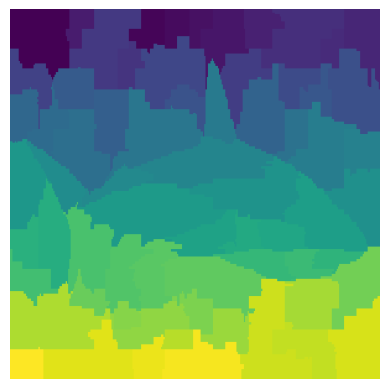

In [5]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0

    return img

normalized_img = transform_image(image_path, IMG_SIZE)


model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

explainer = lime_image.LimeImageExplainer()

exp = explainer.explain_instance(normalized_img[0],
                                 model.predict,
                                 top_labels=5,
                                 hide_color=0,
                                 num_samples=100)

plt.imshow(exp.segments)
plt.axis('off')
plt.show()

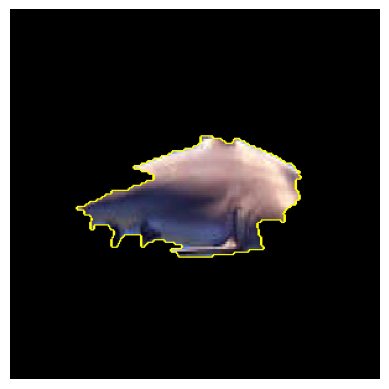

In [6]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

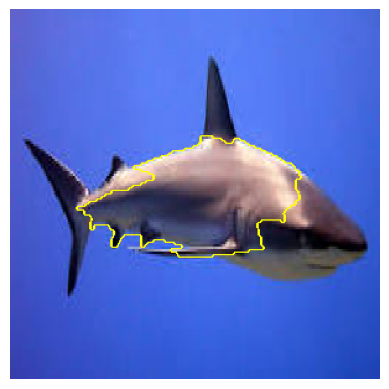

In [7]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

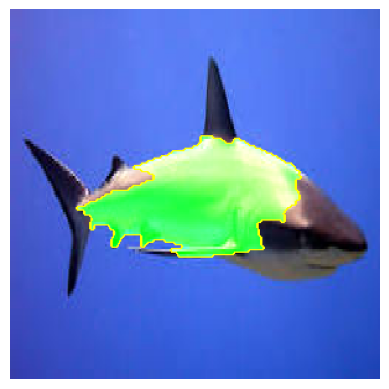

In [8]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

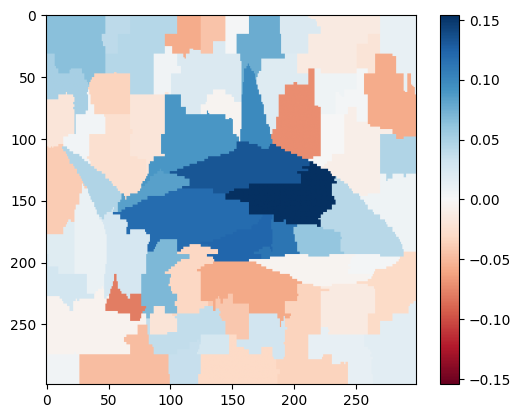

In [9]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

In [10]:
index = 2
print(f"We will deal with predicted class: {top5_pred[index][1]}")

We will deal with predicted class: tiger_shark


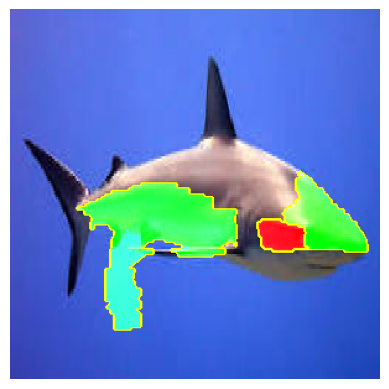

In [11]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)